## Indirectly Shared Domains

**Purpose**: detect indirect resonance by checking if (re-)tweeted URLs are in the "follower" position of news event dyads (see `09-analysis/01-newsevents-dyadic-comparison.ipynb` for details).
- Case A: If a (re-)tweeted URL is in the first position of a dyad, it is in the "lead" position and does not count as indirect resonance.
- Case B: If a (re-)tweeted URL is in the second position of a dyad, it is in the "follower" position and does count as indirect resonance.
    - e.g., If a politician directly (re-)tweets a URL from Fox News, but the first outlet to cover the news event is actually Breitbart.

**Steps**:
1. Load files
    - 1.1 load directly (re-)tweeted domains -> filter out unmatcheable URLs
        - contains columns which are useful for filtering (established right/alternative right, topic, etc.)
    - 1.2 load (re-)tweeted URLs which are linked to news event dyads
        - for detecting indirect resonance
2. Find which (re-)tweeted URLs are matched to multi-article news events
    - 2.1:
        - process the dyads so that each "follower" (`d1`) article also has information about the "lead" (`d0`) article
        - create dataframe where each row is a (re-)tweeted URL which is part of a multi-article news event
    - 2.2: merge the (re-)tweeted URL dataframe with the dyadic URLs dataframe
    - 2.3: split dataframes into two versions based on whether the (re-)tweeted URL is associated with an article in a "lead" (`d0`) of "follower" (`d1`) position
3. Plot "follower" URLs

In [1]:
import os
import pickle
import pandas as pd

%matplotlib inline
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format

In [2]:
from usrightmedia.shared.clusters_utils import extract_dyads

INFO:INCA:Providing verbose output


In [3]:
from usrightmedia.shared.media_references import get_media_outlet_ideo

In [4]:
dyads_dir = os.path.join("..", "..", "data", "02-intermediate", "07-newsevents", "06-softcosine-dyads")
urls_dir = os.path.join("..", "..", "data", "03-analysis")
figs_dir = os.path.join("..", "..", "figures", "indirect")

def save_image(obj, name, height=5.5, width=5.5, units="in", dpi=600):
    obj.save(filename = os.path.join(figs_dir, "png", f'{name}.png'), height=height, width=width, units=units, dpi=dpi)

threshold = "softcos06"

### 1. Load files

#### 1.1 Directly shared URLs

In [5]:
df_direct_urls = pd.read_pickle(os.path.join(urls_dir, "direct_shared_domains.pkl"))

- before filtering

In [6]:
print(f"{len(df_direct_urls)} (re-)tweeted URLs (unfiltered).")
df_direct_urls.groupby('standardized_url').size().sort_values(ascending=False).head(20)

36019 (re-)tweeted URLs (unfiltered).


standardized_url
www.washingtonpost.com/__connectionpool_error__                                                      1692
www.washingtonexaminer.com/tag/donald-trump                                                           626
www.washingtonexaminer.com/tag/barack-obama                                                           173
www.newsmax.com/__connectionpool_error__                                                              142
www.washingtonexaminer.com/tag/hillary-clinton                                                        132
go.com/__client_error__                                                                               123
www.washingtonexaminer.com/tag/supreme-court                                                          101
foxnews.com/__client_error__                                                                           72
washingtonpost.com/__client_error__                                                                    62
washingtonexaminer.com/__clie

- after filtering

In [7]:
df_direct_urls = df_direct_urls.loc[(df_direct_urls['is_selected_outlet'])].reset_index(drop=True)
print(f"{len(df_direct_urls)} (re-)tweeted URLs. Filtered for selected outlets.")

13961 (re-)tweeted URLs. Filtered for selected outlets.


In [8]:
df_direct_urls = df_direct_urls.loc[(df_direct_urls['urlexpander_error']=="no error")].reset_index(drop=True)
print(f"{len(df_direct_urls)} (re-)tweeted URLs. Filtered for selected outlets and no urlExpander error.")

13645 (re-)tweeted URLs. Filtered for selected outlets and no urlExpander error.


In [9]:
df_direct_urls = df_direct_urls.loc[~(df_direct_urls['standardized_url'].str.contains('www.washingtonexaminer.com/tag'))        
                                    & ~(df_direct_urls['standardized_url'].str.contains('www.foxnews.com/category'))
                                    & ~(df_direct_urls['standardized_url'].str.contains('radio.foxnews.com/fox-news-talk'))
                                    & ~(df_direct_urls['standardized_url'].str.contains('radio.foxnews.com/podcast'))
                                    & ~(df_direct_urls['standardized_url'].str.contains('video.fox'))].reset_index(drop=True)
print(f"{len(df_direct_urls)} (re-)tweeted URLs. Filtered for selected outlets, no urlExpander error, and no generic URLs.")
df_direct_urls.groupby('standardized_url').size().sort_values(ascending=False).head(20)

11231 (re-)tweeted URLs. Filtered for selected outlets, no urlExpander error, and no generic URLs.


standardized_url
www.washingtonexaminer.com/policy/economy/hires-rise-to-highest-level-in-17-years                                         33
www.washingtonexaminer.com/va-secretary-disney-doesnt-measure-wait-times-so-why-should-va                                 30
www.foxnews.com/politics/planned-parenthood-coronavirus-stimulus-money-ppp-return                                         24
www.foxbusiness.com/economy/us-wage-growth-hits-17-month-high                                                             20
radio.foxnews.com/player-files/radio.php                                                                                  19
www.washingtonexaminer.com/washington-secrets/record-high-business-optimism-need-for-employees-at-45-year-high            17
www.foxbusiness.com/economy/ppp-51-million-jobs-coronavirus-house-republicans                                             16
www.washingtonexaminer.com/over-100-companies-giving-trump-bonuses-after-tax-victory-tsunami-building       

#### 1.2 Load URLs which are associated with news event dyads

In [10]:
with open(os.path.join(dyads_dir, f'{threshold}_dyads_cx_filtered_IPR.pkl'), 'rb') as file:
      dyads_cx_filtered_IPR = pickle.load(file)
    
dyads_filtered_IPR = extract_dyads(dyads_cx_filtered_IPR)

In [11]:
print(f"{len(dyads_filtered_IPR)} dyads between different doctypes.")

98692 dyads between different doctypes.


- As shown in the example below, each item in a dyad has a `doc_tw` key which lists whether the particular article was directly (re-)tweeted 1+ times.
- We can then use the dyads to figure out if the outlet associated with the directly (re-)tweeted URL was the "leader" in covering this news event or if it was a "follower".

In [12]:
# example
# note: cluster size is based on original cluster size
# It will not necessary match with the count of dyads in dyads_filtered_IPR because dyads_filtered_IPR is filtered to `keep_dyads_bn_diff_doctypes_only=True`
dyads_cx_filtered_IPR["softcos06_9916"]

[({'cluster_id': 'softcos06_9916',
   'cluster_size': 4,
   'doc_id': 'FoxNews_1439280633',
   'doc_publish_date': Timestamp('2019-11-07 17:21:04+0000', tz='UTC'),
   'doc_title': "Donald Trump Jr. blasts 'The View' hosts for Joy Behar's 'blackface' and Whoopi Goldberg comments on Polanski",
   'doctype': 'foxnews',
   'doctype_ideo': 'est',
   'doc_topic': 'topic3',
   'doc_tw': ['jasoninthehouse_1192526992236630016_0']},
  {'cluster_id': 'softcos06_9916',
   'cluster_size': 4,
   'doc_id': 'InfoWars_1439434418',
   'doc_publish_date': Timestamp('2019-11-07 19:25:10+0000', tz='UTC'),
   'doc_title': 'Don Jr. Absolutely Destroys Liberal Hosts of ABC&#8217;s The View',
   'doctype': 'infowars',
   'doctype_ideo': 'alt',
   'doc_topic': 'topic2',
   'doc_tw': []}),
 ({'cluster_id': 'softcos06_9916',
   'cluster_size': 4,
   'doc_id': 'FoxNews_1439280633',
   'doc_publish_date': Timestamp('2019-11-07 17:21:04+0000', tz='UTC'),
   'doc_title': "Donald Trump Jr. blasts 'The View' hosts for 

### 2. Find which (re-)tweeted URLs are matched to multi-article news events
- `softcos06`: `There are 518233 single-article clusters and 62887 multiple-article clusters.`

#### 2.1 Set up dataframe where each row is a (re-)tweeted URL which is part of a multi-article news event

In [13]:
tweeted_docs = []
for dyad in dyads_filtered_IPR:
    for n, item in enumerate(dyad):
        if len(item["doc_tw"]) > 0: # keep articles which were (re-)tweeted 1+ times by a politician
            item["d0_doc_id"] = dyad[0]["doc_id"] # for all articles ("lead" or "follower"), augment with the initiating article's doc_id
            item["d0_doctype"] = dyad[0]["doctype"] # ... augment with the initiating article's doctype
            if n == 0:
                # lead
                item["dyad_pos"] = 0
                item["d1_doc_id"] = None # this is a "lead" article so "follower" (d1) is None
                item["d1_doctype"] = None
            elif n == 1:
                # follower
                item["dyad_pos"] = 1
                item["d1_doc_id"] = item["doc_id"]
                item["d1_doctype"] = item["doctype"]
            tweeted_docs.append(item)
            
# drop_duplicates: The first item (document) within each dyad is identical to the other dyads within the same cluster. Keep the first instance only.
# explode: The doc_tw column contains a list of tweets2_url IDs. 'Explode' the dataframe so that each row corresponds with a (re-)tweeted URL. The values of the other columns are duplicated.
df_dyadic_urls = pd.DataFrame(tweeted_docs)\
               .drop_duplicates(subset=["cluster_id","doc_id"], keep="first")\
               .explode("doc_tw")\
               .reset_index(drop=True)\
               .rename(columns={"doc_tw": "url_id"})
print(f"{len(df_dyadic_urls)} (re-)tweeted URLs are part of multi-article news events.")
df_dyadic_urls

2162 (re-)tweeted URLs are part of multi-article news events.


,cluster_id,cluster_size,doc_id,doc_publish_date,doc_title,doctype,doctype_ideo,doc_topic,url_id,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype
0,softcos06_100,44,DailyCaller_1593668519,2020-04-30 19:50:59+00:00,FBI Planned To Close Michael Flynn Investigati...,dailycaller,est,topic2,RepGosar_1255970074151837698_0,FoxNews_1590605950,foxnews,1,DailyCaller_1593668519,dailycaller
1,softcos06_1000,16,DailyCaller_1637449942,2020-06-17 16:03:18+00:00,Hawley Announces Bill Targeting Bad-Acting Tec...,dailycaller,est,topic2,SenHawleyPress_1280877113118261249_0,FoxNews_1652437807,foxnews,1,DailyCaller_1637449942,dailycaller
2,softcos06_10048,4,FoxNews_1790875424,2020-12-07 19:36:08+00:00,GOP Rep. Ken Buck calls for Hunter Biden speci...,foxnews,est,topic3,RepKenBuck_1336495790735454209_0,FoxNews_1790875424,foxnews,0,None,None
3,softcos06_10048,4,FoxNews_1790875424,2020-12-07 19:36:08+00:00,GOP Rep. Ken Buck calls for Hunter Biden speci...,foxnews,est,topic3,RepKenBuck_1336049448317841424_0,FoxNews_1790875424,foxnews,0,None,None
4,softcos06_10048,4,FoxNews_1790875424,2020-12-07 19:36:08+00:00,GOP Rep. Ken Buck calls for Hunter Biden speci...,foxnews,est,topic3,Jim_Jordan_1336496476067942400_0,FoxNews_1790875424,foxnews,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,softcos06_991,16,WashingtonExaminer_470106918,2016-05-24 15:14:46+00:00,Ryan: VA chief's comments 'disgusting',washingtonexaminer,est,topic1,SpeakerRyan_735213887226806272_0,FoxNews_469768825,foxnews,1,WashingtonExaminer_470106918,washingtonexaminer
2158,softcos06_991,16,WashingtonExaminer_470530063,2016-05-25 15:32:56+00:00,Cruz calls for VA's McDonald to step down,washingtonexaminer,est,topic1,SenTedCruz_735497975728836609_0,FoxNews_469768825,foxnews,1,WashingtonExaminer_470530063,washingtonexaminer
2159,softcos06_9916,4,FoxNews_1439280633,2019-11-07 17:21:04+00:00,Donald Trump Jr. blasts 'The View' hosts for J...,foxnews,est,topic3,jasoninthehouse_1192526992236630016_0,FoxNews_1439280633,foxnews,0,None,None
2160,softcos06_9920,4,FoxNews_738376893,2017-12-06 21:45:00+00:00,"House passes gun reciprocity, faces challenge ...",foxnews,est,topic1,RepRichHudson_938560036858671104_0,WashingtonExaminer_737721767,washingtonexaminer,1,FoxNews_738376893,foxnews


In [14]:
# identifiable (re-)tweeted URLs: is_selected_outlet==True, not a urlExpander error, and not a generic URL
# identifiable multi-article news events: clusters based on softcos06 threshold (may not be comprehensive of all actual news events; tradeoff where higher softcos* means fewer false positives + lower recall)
print(f"{round(len(df_dyadic_urls)/len(df_direct_urls),2)*100}% of identifiable (re-)tweeted URLs are part of identifiable multi-article news events.")

19.0% of identifiable (re-)tweeted URLs are part of identifiable multi-article news events.


In [15]:
print(f"{df_dyadic_urls['cluster_id'].nunique()} distinct news events were (re-)tweeted.")

1356 distinct news events were (re-)tweeted.


In [16]:
# number of (re-)tweets associated with each news event (i.e., cluster_id)
df_dyadic_urls.groupby("cluster_id").size().sort_values(ascending=False)

cluster_id
softcos06_1011     16
softcos06_92       12
softcos06_393      11
softcos06_15       11
softcos06_48181    10
                   ..
softcos06_27214     1
softcos06_27242     1
softcos06_27335     1
softcos06_27426     1
softcos06_9966      1
Length: 1356, dtype: int64

In [17]:
# number of (re-)tweets associated with each outlet
df_dyadic_urls.groupby("doctype").size()

doctype
breitbart              155
dailycaller            208
foxnews               1640
gatewaypundit            4
seanhannity              4
washingtonexaminer     151
dtype: int64

In [18]:
df_dyadic_urls.loc[df_dyadic_urls["cluster_id"]=="softcos06_1011"]

,cluster_id,cluster_size,doc_id,doc_publish_date,doc_title,doctype,doctype_ideo,doc_topic,url_id,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype
17,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,RepRickAllen_1280909146498482176_0,FoxNews_1656249880,foxnews,0,None,None
18,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,CongHuelskamp_1280893313332150273_0,FoxNews_1656249880,foxnews,0,None,None
19,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,RepDougCollins_1280898918486888448_0,FoxNews_1656249880,foxnews,0,None,None
20,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,RepMarkWalker_1280915664249774080_0,FoxNews_1656249880,foxnews,0,None,None
21,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,RepJasonSmith_1280984378340978688_0,FoxNews_1656249880,foxnews,0,None,None
22,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,RepRonEstes_1280978404632903685_0,FoxNews_1656249880,foxnews,0,None,None
23,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,virginiafoxx_1280902040835760129_0,FoxNews_1656249880,foxnews,0,None,None
24,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,RepMarkGreen_1280941009929633793_0,FoxNews_1656249880,foxnews,0,None,None
25,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,AustinScottGA08_1281017493260247041_0,FoxNews_1656249880,foxnews,0,None,None
26,softcos06_1011,16,FoxNews_1656249880,2020-07-08 14:19:10+00:00,Supreme Court rules in favor of Little Sisters...,foxnews,est,topic2,RepDLesko_1280915947352731650_0,FoxNews_1656249880,foxnews,0,None,None


#### 2.2 merge the (re-)tweeted URL dataframe with the dyadic URLs dataframe

In [19]:
df_direct_urls['url_id'] = df_direct_urls['username'] + '_' + df_direct_urls['url_id']
df_direct_urls.head()

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,pew_libdem,pew_consrep,pew_libdem_consrep_diff,ideo_category,ideo_subcategory,ideo_left2right
0,KenCalvert_1016809976789159937_0,2018-07-10 22:22:44,2018-01-01,KenCalvert,www.washingtonexaminer.com/policy/economy/hire...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0
1,KenCalvert_706936239220330498_0,2016-03-07 20:15:08,2016-01-01,KenCalvert,www.washingtonexaminer.com/how-a-new-bill-to-f...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0
2,RepComstock_735190770035138560_0,2016-05-24 19:28:33,2016-01-01,RepComstock,www.washingtonexaminer.com/lawmaker-let-privat...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0
3,RepByrne_971799132707926016_0,2018-03-08 17:25:43,2018-01-01,RepByrne,www.washingtonexaminer.com/how-to-end-governme...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0
4,RepChrisStewart_1204042988285919233_0,2019-12-09 14:19:53,2019-01-01,RepChrisStewart,www.washingtonexaminer.com/opinion/utah-republ...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0


In [20]:
df_urls = df_direct_urls.merge(right=df_dyadic_urls, how="left", on="url_id")

In [21]:
# formatting only: convert doctype to proper-cased outlet name
outlet_map = dict(zip(get_media_outlet_ideo()['outlet_std'], get_media_outlet_ideo()['outlet']))
outlet_map

{'vox': 'Vox',
 'huffingtonpost': 'Huffington Post',
 'guardian': 'The Guardian',
 'vice': 'VICE',
 'newyorktimes': 'New York Times',
 'npr': 'NPR',
 'politico': 'Politico',
 'washingtonpost': 'Washington Post',
 'bbc': 'BBC',
 'time': 'Time',
 'msnbc': 'MSNBC',
 'buzzfeed': 'BuzzFeed',
 'pbs': 'PBS',
 'thehill': 'The Hill',
 'cnn': 'CNN',
 'newsweek': 'Newsweek',
 'businessinsider': 'Business Insider',
 'wallstreetjournal': 'Wall Street Journal',
 'nbcnews': 'NBC News',
 'univision': 'Univision',
 'usatoday': 'USA Today',
 'abcnews': 'ABC News',
 'cbsnews': 'CBS News',
 'newyorkpost': 'New York Post',
 'washingtonexaminer': 'Washington Examiner',
 'foxnews': 'Fox News',
 'dailycaller': 'Daily Caller',
 'breitbart': 'Breitbart',
 'seanhannity': 'Sean Hannity',
 'rushlimbaugh': 'Rush Limbaugh',
 'newsmax': 'Newsmax',
 'oneamericanews': 'One America News',
 'gatewaypundit': 'The Gateway Pundit',
 'infowars': 'InfoWars',
 'americanrenaissance': 'American Renaissance',
 'vdare': 'VDARE',
 

In [22]:
df_urls['d0_outlet'] = df_urls['d0_doctype'].map(outlet_map)
df_urls['d1_outlet'] = df_urls['d1_doctype'].map(outlet_map)

In [23]:
df_urls.head()

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,doctype,doctype_ideo,doc_topic,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype,d0_outlet,d1_outlet
0,KenCalvert_1016809976789159937_0,2018-07-10 22:22:44,2018-01-01,KenCalvert,www.washingtonexaminer.com/policy/economy/hire...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KenCalvert_706936239220330498_0,2016-03-07 20:15:08,2016-01-01,KenCalvert,www.washingtonexaminer.com/how-a-new-bill-to-f...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RepComstock_735190770035138560_0,2016-05-24 19:28:33,2016-01-01,RepComstock,www.washingtonexaminer.com/lawmaker-let-privat...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RepByrne_971799132707926016_0,2018-03-08 17:25:43,2018-01-01,RepByrne,www.washingtonexaminer.com/how-to-end-governme...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RepChrisStewart_1204042988285919233_0,2019-12-09 14:19:53,2019-01-01,RepChrisStewart,www.washingtonexaminer.com/opinion/utah-republ...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.3 filtered versions for (re-)tweets which are in "lead" position (`dyad_pos==0`) vs. "follower" position (`dyad_pos==1`)

In [24]:
df_urls_d0 = df_urls.loc[df_urls['dyad_pos']==0].reset_index(drop=True)
df_urls_d1 = df_urls.loc[df_urls['dyad_pos']==1].reset_index(drop=True)
# not exporting at this point

In [25]:
with pd.option_context("display.max_colwidth", None):
    display(df_urls_d0['d1_outlet'].unique())

array([nan], dtype=object)

In [26]:
with pd.option_context("display.max_colwidth", None):
    display(df_urls_d1)

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,doctype,doctype_ideo,doc_topic,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype,d0_outlet,d1_outlet
0,DesJarlaisTN04_859058573053186048_0,2017-05-01 14:54:59,2017-01-01,DesJarlaisTN04,www.washingtonexaminer.com/trump-signs-executive-action-aimed-at-va-accountability,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic1,DailyCaller_615309601,dailycaller,1.0,WashingtonExaminer_822152161,washingtonexaminer,Daily Caller,Washington Examiner
1,SenTedCruz_1153377065275744256_0,2019-07-22 18:51:35,2019-01-01,SenTedCruz,www.washingtonexaminer.com/news/ted-cruz-and-bill-cassidy-file-resolution-to-designate-antifa-as-a-domestic-terrorist-organization,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic2,GatewayPundit_1342539334,gatewaypundit,1.0,WashingtonExaminer_1356440915,washingtonexaminer,The Gateway Pundit,Washington Examiner
2,replouiegohmert_689917877424648192_0,2016-01-20 21:10:14,2016-01-01,replouiegohmert,www.washingtonexaminer.com/dhs-500-000-people-overstayed-their-us-visas-in-2015,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic2,GatewayPundit_416550225,gatewaypundit,1.0,WashingtonExaminer_416560799,washingtonexaminer,The Gateway Pundit,Washington Examiner
3,JohnCornyn_1066710361397702657_0,2018-11-25 15:09:03,2018-01-01,JohnCornyn,www.washingtonexaminer.com/opinion/columnists/byron-york-when-it-comes-to-undermining-faith-in-democracy-another-low-point,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic1,FoxNews_1072633614,foxnews,1.0,WashingtonExaminer_1176656301,washingtonexaminer,Fox News,Washington Examiner
4,SteveScalise_783727193406967808_0,2016-10-05 17:54:58,2016-01-01,SteveScalise,www.washingtonexaminer.com/oklahoma-obamacare-plans-face-76-percent-hike,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic2,Newsmax_713083039,newsmax,1.0,WashingtonExaminer_521764106,washingtonexaminer,Newsmax,Washington Examiner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,jasoninthehouse_1294638820449689604_0,2020-08-15 14:15:22,2020-01-01,jasoninthehouse,hannity.com/media-room/chicago-chaos-looters-attack-ronald-mcdonald-charity-house-with-sick-children-families-inside,hannity.com,no error,Sean Hannity,seanhannity,True,...,seanhannity,est,topic2,FoxNews_1681898986,foxnews,1.0,SeanHannity_1682882148,seanhannity,Fox News,Sean Hannity
1265,jasoninthehouse_1280298580536745988_0,2020-07-07 00:32:23,2020-01-01,jasoninthehouse,hannity.com/media-room/grieving-father-they-say-black-lives-matter-you-killed-your-own-you-killed-a-child,hannity.com,no error,Sean Hannity,seanhannity,True,...,seanhannity,est,topic1,FoxNews_1653721474,foxnews,1.0,SeanHannity_1676620439,seanhannity,Fox News,Sean Hannity
1266,RepMattGaetz_1183871220967706624_0,2019-10-14 22:24:28,2019-01-01,RepMattGaetz,hannity.com/media-room/denied-entry-rep-matt-gaetz-kicked-out-of-democrats-impeachment-hearing,hannity.com,no error,Sean Hannity,seanhannity,True,...,seanhannity,est,topic2,GatewayPundit_1418591085,gatewaypundit,1.0,SeanHannity_1468929651,seanhannity,The Gateway Pundit,Sean Hannity
1267,RepMattGaetz_1176169365974265857_0,2019-09-23 16:20:03,2019-01-01,RepMattGaetz,hannity.com/media-room/gaetz-on-hannity-were-seeing-a-true-fissure-in-the-democratic-party,hannity.com,no error,Sean Hannity,seanhannity,True,...,seanhannity,est,topic2,FoxNews_1394270710,foxnews,1.0,SeanHannity_1397363598,seanhannity,Fox News,Sean Hannity


In [27]:
df_dyadic_urls.groupby('url_id').size().sort_values(ascending=False)

url_id
RepBrianBabin_1273741996511952899_0    2
RepTomRice_750467868614090752_0        1
RepTomEmmer_1281254311834648576_0      1
RepTomGarrett_1111622761842180097_0    1
RepTomGarrett_852171833336057856_0     1
                                      ..
RepEdRoyce_753687474111651842_0        1
RepEdRoyce_1016680154419122177_0       1
RepDougCollins_926425997813088256_0    1
RepDougCollins_690297770465452032_0    1
virginiafoxx_817372135480029184_0      1
Length: 2161, dtype: int64

In [28]:
# One url_id is associated with 2 different clusters
# appears that Fox News' RSS feed posted the original on June 18, 2020 and re-posted an updated(?) version on July 9, 2020
with pd.option_context("display.max_colwidth", None):
    display(df_urls_d1.loc[df_urls_d1["url_id"]=="RepBrianBabin_1273741996511952899_0"])

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,doctype,doctype_ideo,doc_topic,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype,d0_outlet,d1_outlet
912,RepBrianBabin_1273741996511952899_0,2020-06-18 22:18:51,2020-01-01,RepBrianBabin,www.foxnews.com/politics/supreme-court-rules-against-trump-administration-over-move-to-end-daca-program,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic2,WashingtonExaminer_1656807117,washingtonexaminer,1.0,FoxNews_1656855082,foxnews,Washington Examiner,Fox News
913,RepBrianBabin_1273741996511952899_0,2020-06-18 22:18:51,2020-01-01,RepBrianBabin,www.foxnews.com/politics/supreme-court-rules-against-trump-administration-over-move-to-end-daca-program,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic3,DailyCaller_1637707608,dailycaller,1.0,FoxNews_1638393581,foxnews,Daily Caller,Fox News


In [29]:
# RepBrianBabin_1273741996511952899_0: drop more recent article within duplicate
df_urls_d1 = df_urls_d1[df_urls_d1['d1_doc_id'] != 'FoxNews_1656855082'].reset_index(drop=True)

In [30]:
len(df_urls_d0) + len(df_urls_d1)

2161

In [31]:
# df_urls_d1: (re-)tweet was associated with 'follower' instance
df_urls_d1.to_pickle(os.path.join(urls_dir, "indirect_shared_domains_through_dyads.pkl"))

### 3. Plot "follower" URLs

In [32]:
len(df_urls_d1)

1268

In [33]:
%matplotlib inline

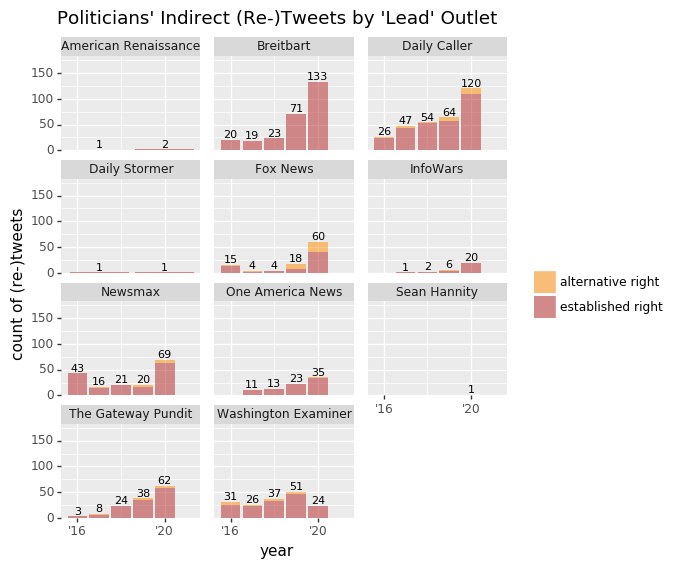

<ggplot: (8738114467581)>

In [34]:
# Politicians' Indirect (Re-)Tweets by 'Lead' Outlet (Colored by 'Follower' Outlet)
plt_indirect = (p9.ggplot(data=df_urls_d1,
                    mapping=p9.aes(x='created_at_year'))
                 + p9.geom_bar(p9.aes(fill='ideo_subcategory'), stat='count', # ideo_subcategory is for d1
                            alpha = 0.5)
                 + p9.scale_fill_manual(values=['darkorange', 'firebrick', 'steelblue', 'grey'])
                 + p9.geom_text(
                     p9.aes(label=p9.after_stat('count')),
                     stat='count',
                     va='bottom',
                     size=8
                 )
                 + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='4 years')
                 + p9.scale_y_continuous(expand=(0, 0, 0, 50))
                 + p9.facet_wrap("d0_outlet", labeller='label_value', ncol=3)
                 + p9.theme(figure_size=(5.75, 6.0),
                     subplots_adjust={'wspace': 0.10,
                                      'hspace': 0.30
                                     })
                 + p9.labs(title="Politicians' Indirect (Re-)Tweets by 'Lead' Outlet",
                        fill='',
                        x='year',
                        y='count of (re-)tweets')
                )

display(plt_indirect)

In [35]:
save_image(plt_indirect, "outlets_right_shared_by_year_indirect", width=5.75, height=6.0, units="in")

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5.75 x 6.0 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/indirect/png/outlets_right_shared_by_year_indirect.png


In [36]:
df_urls_d1.columns

Index(['url_id', 'created_at', 'created_at_year', 'username',
       'standardized_url', 'url_netloc', 'urlexpander_error', 'outlet',
       'outlet_std', 'is_selected_outlet', 'pew_libdem', 'pew_consrep',
       'pew_libdem_consrep_diff', 'ideo_category', 'ideo_subcategory',
       'ideo_left2right', 'cluster_id', 'cluster_size', 'doc_id',
       'doc_publish_date', 'doc_title', 'doctype', 'doctype_ideo', 'doc_topic',
       'd0_doc_id', 'd0_doctype', 'dyad_pos', 'd1_doc_id', 'd1_doctype',
       'd0_outlet', 'd1_outlet'],
      dtype='object')

In [37]:
with pd.option_context('display.max_colwidth', None):
    display(df_urls_d1.loc[df_urls_d1['d0_doctype']=='americanrenaissance'])

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,doctype,doctype_ideo,doc_topic,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype,d0_outlet,d1_outlet
354,RepLoudermilk_1217840618078113799_0,2020-01-16 16:06:44,2020-01-01,RepLoudermilk,www.foxnews.com/politics/nyc-sanctuary-city-policy-under-fire,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic1,AmericanRenaissance_1495026172,americanrenaissance,1.0,FoxNews_1517170333,foxnews,American Renaissance,Fox News
438,RepBrianBabin_1217933512738852865_0,2020-01-16 22:15:52,2020-01-01,RepBrianBabin,www.foxnews.com/politics/nyc-sanctuary-city-policy-under-fire,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic1,AmericanRenaissance_1495026172,americanrenaissance,1.0,FoxNews_1517170333,foxnews,American Renaissance,Fox News
817,RepMarkWalker_824362661508943873_0,2017-01-25 21:05:49,2017-01-01,RepMarkWalker,www.foxnews.com/politics/education-department-report-finds-billions-spent-under-obama-had-no-impact-on-achievement,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic1,AmericanRenaissance_571311262,americanrenaissance,1.0,FoxNews_572052805,foxnews,American Renaissance,Fox News


In [38]:
with pd.option_context('display.max_colwidth', None):
    display(df_urls_d1.loc[df_urls_d1['d0_doctype']=='dailystormer'])

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,doctype,doctype_ideo,doc_topic,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype,d0_outlet,d1_outlet
714,SenHawleyPress_1255975777528619009_0,2020-04-30 21:42:14,2020-01-01,SenHawleyPress,www.foxnews.com/politics/hawley-meatpacking-titans-coronavirus-monopoly-farmers,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic1,DailyStormer_1590014524,dailystormer,1.0,FoxNews_1592642771,foxnews,Daily Stormer,Fox News
994,DrPhilRoe_829852767086850048_0,2017-02-10 00:41:32,2017-01-01,DrPhilRoe,www.foxnews.com/politics/defiant-trump-tweets-see-you-in-court-after-ruling-again-blocks-immigration-order,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic1,DailyStormer_576843628,dailystormer,1.0,FoxNews_694938422,foxnews,Daily Stormer,Fox News


In [39]:
with pd.option_context('display.max_colwidth', None):
    display(df_urls_d1.loc[df_urls_d1['d0_doctype']=='infowars'])

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,doctype,doctype_ideo,doc_topic,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype,d0_outlet,d1_outlet
156,RepGosar_1222171207967133696_0,2020-01-28 14:54:57,2020-01-01,RepGosar,dailycaller.com/2020/01/27/don-lemon-cnn-panel-laugh-trump-voters,dailycaller.com,no error,Daily Caller,dailycaller,True,...,dailycaller,est,topic3,InfoWars_1505235758,infowars,1.0,DailyCaller_1506779782,dailycaller,InfoWars,Daily Caller
213,RepGosar_1145749040618856448_0,2019-07-01 17:40:32,2019-01-01,RepGosar,dailycaller.com/2019/06/29/new-york-times-public-shame-border-agents,dailycaller.com,no error,Daily Caller,dailycaller,True,...,dailycaller,est,topic1,InfoWars_1325367126,infowars,1.0,DailyCaller_1325348705,dailycaller,InfoWars,Daily Caller
297,MarshaBlackburn_1306976793665122305_0,2020-09-18 15:22:04,2020-01-01,MarshaBlackburn,www.foxnews.com/politics/tucker-carlson-says-alleged-nashville-coronavirus-data-cover-up-other-obfuscations-unforgivable,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic3,InfoWars_1714032297,infowars,1.0,FoxNews_1714611182,foxnews,InfoWars,Fox News
299,RepMarkWalker_1002606487242530816_0,2018-06-01 17:43:08,2018-01-01,RepMarkWalker,www.foxnews.com/politics/trump-says-singapore-summit-with-kim-is-back-on-after-meeting-north-korean-official,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic1,InfoWars_881457108,infowars,1.0,FoxNews_890466270,foxnews,InfoWars,Fox News
321,RepThomasMassie_1283851374820818952_0,2020-07-16 19:49:55,2020-01-01,RepThomasMassie,www.foxnews.com/media/massie-house-gop-remove-all-troops-afghanistan,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic1,InfoWars_1661154791,infowars,1.0,FoxNews_1663794983,foxnews,InfoWars,Fox News
350,SenTomCotton_1250569296272637952_0,2020-04-15 23:38:49,2020-01-01,SenTomCotton,www.foxnews.com/politics/coronavirus-wuhan-lab-china-compete-us-sources,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic3,InfoWars_1577995458,infowars,1.0,FoxNews_1579286418,foxnews,InfoWars,Fox News
355,SenatorLoeffler_1253015540488118274_0,2020-04-22 17:39:19,2020-01-01,SenatorLoeffler,www.foxnews.com/politics/loeffler-urges-trump-administration-to-demand-significant-concessions-in-us-china-trade-deal-amid-coronavirus,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic2,InfoWars_1577995458,infowars,1.0,FoxNews_1585924829,foxnews,InfoWars,Fox News
400,SenatorLoeffler_1325507188450861057_0,2020-11-08 18:35:15,2020-01-01,SenatorLoeffler,www.foxnews.com/politics/loeffler-bill-ramp-up-penalties-for-election-interference,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic2,InfoWars_1718258487,infowars,1.0,FoxNews_1720568671,foxnews,InfoWars,Fox News
461,RepMattGaetz_1186276249498505216_0,2019-10-21 13:41:12,2019-01-01,RepMattGaetz,www.foxnews.com/opinion/biggs-and-gaetz-on-syria,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic3,InfoWars_1417260086,infowars,1.0,FoxNews_1422868504,foxnews,InfoWars,Fox News
497,SenatorLoeffler_1311072237685014530_0,2020-09-29 22:35:54,2020-01-01,SenatorLoeffler,www.foxnews.com/politics/loeffler-bill-ramp-up-penalties-for-election-interference,foxnews.com,no error,Fox News,foxnews,True,...,foxnews,est,topic2,InfoWars_1718258487,infowars,1.0,FoxNews_1720568671,foxnews,InfoWars,Fox News
